In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [48]:
# Đọc dữ liệu train, validation và test
train_data = pd.read_csv('./data/train.csv')
val_data = pd.read_csv('./data/validation.csv')
test_data = pd.read_csv('./data/test.csv')

# Lấy đầu vào (features) và đầu ra (target)
X_train = train_data.drop(columns=['temp_c']).values
y_train = train_data['temp_c'].values

X_val = val_data.drop(columns=['temp_c']).values
y_val = val_data['temp_c'].values

X_test = test_data.drop(columns=['temp_c']).values
y_test = test_data['temp_c'].values

# Chuẩn hóa dữ liệu (đưa về khoảng [0, 1])
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Hàm tạo chuỗi thời gian
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

# Đặt chiều dài chuỗi thời gian
sequence_length = 30

# Tạo chuỗi dữ liệu cho train, validation, và test
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, sequence_length)

print(f"Shape of X_train_seq: {X_train_seq.shape}")
print(f"Shape of y_train_seq: {y_train_seq.shape}")

Shape of X_train_seq: (738, 30, 8)
Shape of y_train_seq: (738,)


In [50]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam  # Đảm bảo Adam được import

# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(units=50),
    Dense(units=1)  # Dự đoán một giá trị
])

# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Định nghĩa các callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
csv_logger = CSVLogger('training_log.csv', append=False)  # Lưu log vào file 'training_log.csv'

# Huấn luyện mô hình
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, csv_logger],  # Thêm csv_logger vào danh sách callbacks
    verbose=1
)

Epoch 1/50


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 625.4337 - val_loss: 403.1507
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 356.1644 - val_loss: 286.9344
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 275.6212 - val_loss: 239.1962
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 226.6684 - val_loss: 202.1606
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 189.9204 - val_loss: 169.5811
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 159.3262 - val_loss: 143.0911
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 132.3471 - val_loss: 120.7022
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 110.7438 - val_loss: 101.7570
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 97.1551 - val_loss: 85.7433
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 79.0635 - val_loss: 72.5379
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 66.2841 - val_loss: 61.6460
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━

In [51]:
# Dự đoán trên tập kiểm tra
y_pred_seq = model.predict(X_test_seq)

# Chuyển giá trị dự đoán về khoảng giá trị ban đầu
y_pred_original = y_pred_seq.flatten()
y_test_original = y_test_seq

# Tính toán RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"RMSE on test set: {rmse:.2f}")
print(f"MAE on test set: {mae:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
RMSE on test set: 3.64
MAE on test set: 2.99


In [52]:
def forecast_future(data, model, steps, sequence_length):
    future = []
    current_sequence = data[-sequence_length:]  # Lấy chuỗi cuối cùng
    
    for i in range(steps):
        # Đảm bảo dữ liệu có đúng kích thước
        current_sequence = current_sequence.reshape(1, sequence_length, -1)
        
        # Dự báo giá trị tiếp theo
        next_value = model.predict(current_sequence, verbose=0)
        
        # Lưu giá trị dự báo
        future.append(next_value[0, 0])
        print(f"Dự báo bước {i + 1}: {next_value[0, 0]}")  # In ra từng bước dự báo
        
        # Tạo một giá trị đặc trưng đầy đủ
        next_features = current_sequence[:, -1, :].copy()  # Sao chép hàng cuối cùng
        next_features[0, 0] = next_value[0, 0]  # Thay giá trị nhiệt độ dự đoán
        
        # Cập nhật chuỗi dữ liệu với giá trị mới
        current_sequence = np.concatenate([current_sequence[:, 1:, :], next_features.reshape(1, 1, -1)], axis=1)
    
    return np.array(future)

# Dự báo 7 ngày tiếp theo
print("Dự báo 7 ngày tiếp theo bắt đầu...")
future_forecast = forecast_future(X_test_scaled, model, steps=7, sequence_length=sequence_length)

# In ra kết quả dự báo
print("\nDự báo nhiệt độ 7 ngày tiếp theo:")
print(future_forecast)

Dự báo 7 ngày tiếp theo bắt đầu...
Dự báo bước 1: 26.118440628051758
Dự báo bước 2: 26.115131378173828
Dự báo bước 3: 26.110212326049805
Dự báo bước 4: 26.10112953186035
Dự báo bước 5: 26.08966064453125
Dự báo bước 6: 26.076887130737305
Dự báo bước 7: 26.067955017089844

Dự báo nhiệt độ 7 ngày tiếp theo:
[26.11844  26.115131 26.110212 26.10113  26.08966  26.076887 26.067955]


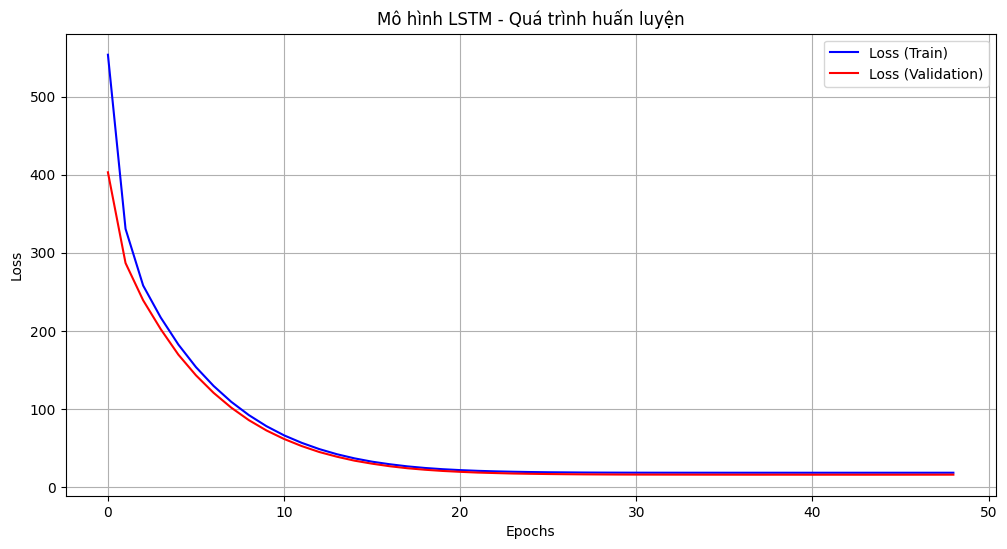

In [53]:
# Trực quan hóa quá trình huấn luyện
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss (Train)', color='blue')
plt.plot(history.history['val_loss'], label='Loss (Validation)', color='red')
plt.title('Mô hình LSTM - Quá trình huấn luyện')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# Lưu mô hình
model.save("lstm_weather_model.h5")

# Tải lại mô hình
from tensorflow.keras.models import load_model
model = load_model("lstm_weather_model.h5")